## 2 Data

In [2]:
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import datetime
folder = "solutionsSeries/"
data = pd.read_csv(folder + "data.csv", sep=';')
data['date'] = pd.to_datetime(data['date'])  # First, ensure that "date" is in datetime format

C:\Users\edoul\AppData\Local\Temp\ipykernel_20908\26293643.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
len(data)

1470787

In [4]:
data.head()

,permno,date,Rn,shrout,prc,mcap,mcap_l,rf,Rm,const,Rn_e,Rm_e
0,10092,2000-09-29,-0.196429,11865.0,16.8750,200221.8750,NaN,0.004933,-0.051154,1,-0.201362,-0.056087
1,10092,2000-10-31,-0.144444,11865.0,14.4375,171300.9375,200221.8750,0.005023,-0.024480,1,-0.149467,-0.029503
2,10092,2000-11-30,-0.251082,12080.0,10.8125,130615.0000,171300.9375,0.005099,-0.102365,1,-0.256181,-0.107464
3,10092,2000-12-29,-0.173410,12080.0,8.9375,107965.0000,130615.0000,0.004808,0.020450,1,-0.178218,0.015642
4,10092,2001-01-31,0.588811,12080.0,14.2000,171536.0000,107965.0000,0.004023,0.039573,1,0.584788,0.035550


## 3 Betting against Beta strategy (BaB)

#### (a) Computation of time-varying Beta

In [5]:
# (a)
# 0. Remove nans
data = data.dropna(subset=['mcap_l','Rn_e','Rm_e']).copy()

# 2. Estimate Rolling Betas
cov_nm = data.set_index('date').groupby('permno')[['Rn_e','Rm_e']].rolling(window = 60, min_periods=36).cov()
beta_n = (cov_nm.iloc[0::2,1].droplevel(2)/cov_nm.iloc[1::2,1].droplevel(2))

beta_n = beta_n.dropna().reset_index().rename(columns={'Rm_e':'beta'})

# 3. Merge betas with data
data = data.merge(beta_n, on=['permno','date'], how='left')

# get rid of nan values
data = data.dropna(subset=['beta']).copy()

# 4. Remove outliers
data['beta'] = data['beta'].clip(data['beta'].quantile(0.05),data['beta'].quantile(0.95))


In [6]:
#count beta not nan
print(data['beta'].count())

len(data['beta'])

1188946


1188946

#### (B) Beta Deciles

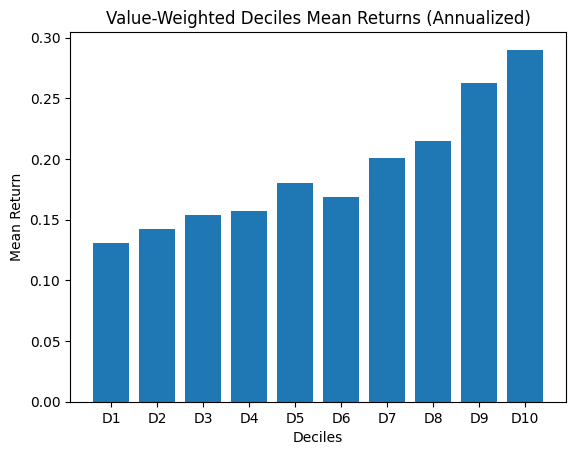

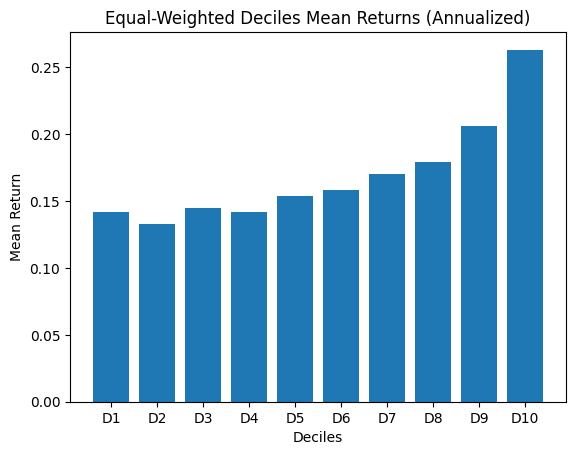

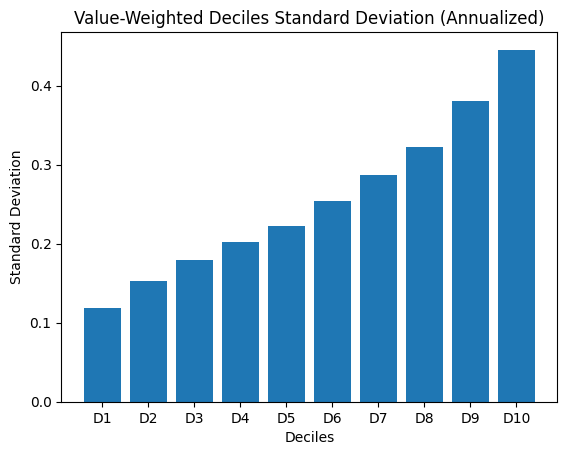

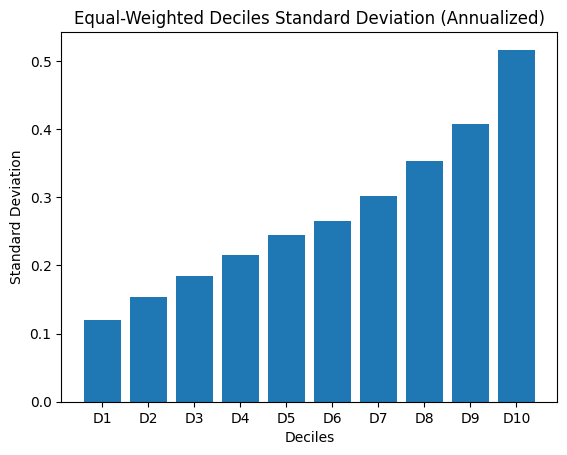

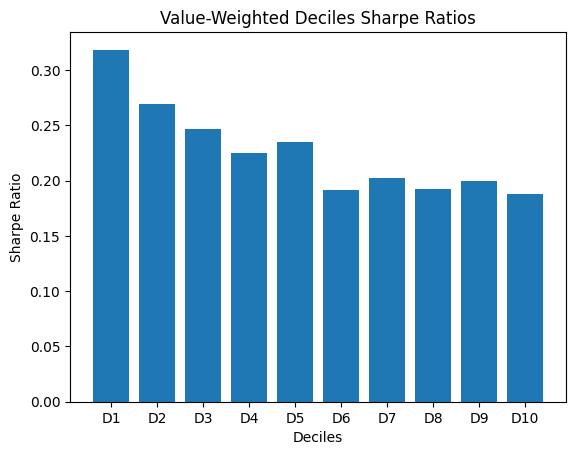

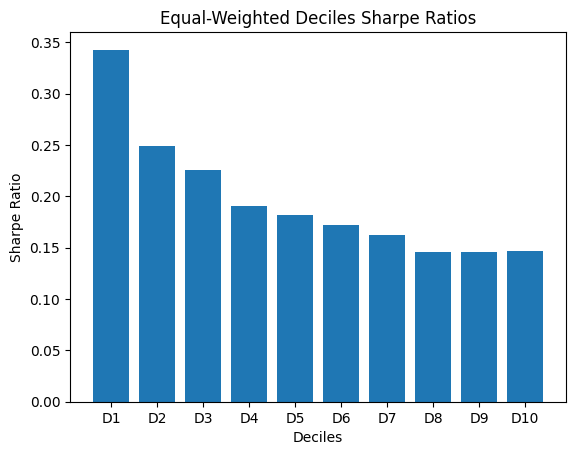

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'data' is a DataFrame with columns: 'date', 'beta', 'mcap', and 'Rn'
# (b)
# 1. Deciles
data['beta_Q'] = data.groupby('date')['beta'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop'))

# 2. Market Weights within deciles
data['vw_Q'] = data['mcap'] / data.groupby(['date', 'beta_Q'])['mcap'].transform('sum')

# 3. VW Portfolios
data['beta_ret_vw'] = data['vw_Q'] * data['Rn']
ret_vw = data.groupby(['date', 'beta_Q'])['beta_ret_vw'].sum().reset_index()
vw_ret_mean = ret_vw.groupby('beta_Q')['beta_ret_vw'].mean()

# 4. Equal-Weighted portfolios
ret_ew = data.groupby(['date', 'beta_Q'])['Rn'].mean().reset_index()
ew_ret_mean = ret_ew.groupby('beta_Q')['Rn'].mean()

# Calculate standard deviations
vw_ret_std = ret_vw.groupby('beta_Q')['beta_ret_vw'].std()
ew_ret_std = ret_ew.groupby('beta_Q')['Rn'].std()

# Compute the Sharpe Ratios with excess returns Rn_e for the Value-Weighted portfolios
data['beta_ret_vw_e'] = data['vw_Q']*data['Rn_e']
ret_vw_e = data.groupby(['date','beta_Q'])['beta_ret_vw_e'].sum().reset_index()
vw_ret_mean_e = ret_vw_e.groupby('beta_Q')['beta_ret_vw_e'].mean()
vw_ret_std_e = ret_vw_e.groupby('beta_Q')['beta_ret_vw_e'].std()
vw_sharpe_e = vw_ret_mean_e/vw_ret_std_e*np.sqrt(12)

# Compute the Sharpe Ratios with excess returns Rn_e for the Equal-Weighted portfolios
ret_ew_e = data.groupby(['date','beta_Q'])['Rn_e'].mean().reset_index()
ew_ret_mean_e = ret_ew_e.groupby('beta_Q')['Rn_e'].mean()
ew_ret_std_e = ret_ew_e.groupby('beta_Q')['Rn_e'].std()
ew_sharpe_e = ew_ret_mean_e/ew_ret_std_e*np.sqrt(12)

# 5. Plot Histograms
deciles = ['D' + str(x) for x in np.arange(1, 11)]

#save plots
# Plot VW mean returns
plt.bar(deciles, vw_ret_mean * 12)
plt.title('Value-Weighted Deciles Mean Returns (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Mean Return')
plt.savefig('vw_ret_mean.png')
plt.show()

# Plot EW mean returns
plt.bar(deciles, ew_ret_mean * 12)
plt.title('Equal-Weighted Deciles Mean Returns (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Mean Return')
plt.savefig('ew_ret_mean.png')
plt.show()

# Plot VW standard deviations
plt.bar(deciles, vw_ret_std * np.sqrt(12))
plt.title('Value-Weighted Deciles Standard Deviation (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Standard Deviation')
plt.savefig('vw_ret_std.png')
plt.show()

# Plot EW standard deviations
plt.bar(deciles, ew_ret_std * np.sqrt(12))
plt.title('Equal-Weighted Deciles Standard Deviation (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Standard Deviation')
plt.savefig('ew_ret_std.png')
plt.show()

# Plot VW Sharpe ratios
plt.bar(deciles, vw_sharpe_ratio)
plt.title('Value-Weighted Deciles Sharpe Ratios')
plt.xlabel('Deciles')
plt.ylabel('Sharpe Ratio')
plt.savefig('vw_sharpe_ratio.png')
plt.show()

# Plot EW Sharpe ratios
plt.bar(deciles, ew_sharpe_ratio)
plt.title('Equal-Weighted Deciles Sharpe Ratios')
plt.xlabel('Deciles')
plt.ylabel('Sharpe Ratio')
plt.savefig('ew_sharpe_ratio.png')
plt.show()




TODO
- Question: Summarize our findings. Is the evidence consistent with the CAPM?
- Answer:

#### (c/d) Construct BAB factor

In [11]:
# Weights
data['z'] = data.groupby('date')['beta'].transform(lambda x: x.rank())
data['z_'] = data['z']-data.groupby('date')['z'].transform('mean')
data['k'] = np.abs(data['z_'])
data['k'] = 2/data.groupby('date')['k'].transform('sum')
data['w_H'] = data['k'] * data['z_'] * (data['z_']>0) 
data['w_L'] = -data['k'] * data['z_'] * (data['z_']<0) 

# Weighted returns and beta
data['beta_H'] = data['w_H'] * data['beta']
data['beta_L'] = data['w_L'] * data['beta']
data['R_H'] = data['w_H'] * data['Rn']
data['R_L'] = data['w_L'] * data['Rn']
BAB = data.groupby('date')[['R_H','R_L','beta_H','beta_L']].sum().reset_index()

# Levered and unlevered returns
BAB['BAB1'] = BAB['R_L'] - BAB['R_H']
BAB['BAB2'] = (BAB['R_L_e']/BAB['beta_L']) - ( BAB['R_H_e']/BAB['beta_H'] )


In [13]:
BAB.head()

,date,R_H,R_L,R_H_e,R_L_e,beta_H,beta_L,BAB1,BAB2
0,1928-01-31,0.019097,-0.006957,0.015767,-0.010286,1.522616,0.497003,-0.026054,-0.031052
1,1928-02-29,-0.016198,-0.023230,-0.019025,-0.026056,1.538988,0.515339,-0.007031,-0.038199
2,1928-03-31,0.109825,0.106972,0.107019,0.104166,1.480198,0.498755,-0.002853,0.136551
3,1928-04-30,0.060100,0.075325,0.056933,0.072158,1.484202,0.518877,0.015224,0.100705
4,1928-05-31,0.014240,0.031413,0.011000,0.028173,1.480773,0.517211,0.017173,0.047042


In [18]:
# Merge Market and Risk free Rate
tmp = pd.merge(BAB,data[['date','Rm_e']].drop_duplicates(), on=['date'], how='left')
tmp['alpha'] = 1

# Alpha and Beta
import statsmodels.api as sm
tmp = tmp.dropna()
OLS_Reg = sm.OLS(tmp['BAB2'], tmp[['alpha','Rm_e']]).fit()

# Report the mean,standard deviation, and sharpe ratio and CAPM alpha of the BAB factor
print('Mean:', tmp['BAB2'].mean())
print('Std:', tmp['BAB2'].std())
print('Sharpe ratio:', tmp['BAB2'].mean()/tmp['BAB2'].std())
print('Monthly CAPM Alpha:', OLS_Reg.params['alpha'])

Mean: 0.00696979509434715
Std: 0.038123371295840286
Sharpe ratio: 0.1828221077370363
Monthly CAPM Alpha: 0.007852571163538276
